In [1]:
#py37 env
import numpy as np
from datetime import datetime, timedelta
import sys
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import os
import urllib.request
from multiprocessing import Pool
from tqdm import tqdm  
import datetime as dt
from datetime import timedelta  
import numpy as np
from scipy.io import netcdf_file

sys.path.append('./Tools')
from OC_nc2npz import ReadHYCOMData
from GeneralGeoTools import PlotGeneralGeoData


In [2]:
#Run once to read HYCOM data (netcfd) and write in npz format
SaveHycomPath="./InputData/OceanCurrent/RawHycomData_2007_2013.npz"
ReadHYCOMData(SaveHycomPath) #Read HYCOM data


100%|██████████| 1282/1282 [00:25<00:00, 49.77it/s]


# Check Data

In [2]:
HycomPath="./InputData/OceanCurrent/RawHycomData_2007_2013.npz"
Data=np.load(HycomPath,allow_pickle=True)
OCSpeed=Data["OCSpeed"]
LatLong=Data["LatLong"]
depth=Data["depth"]
TimeList=Data["TimeList"]

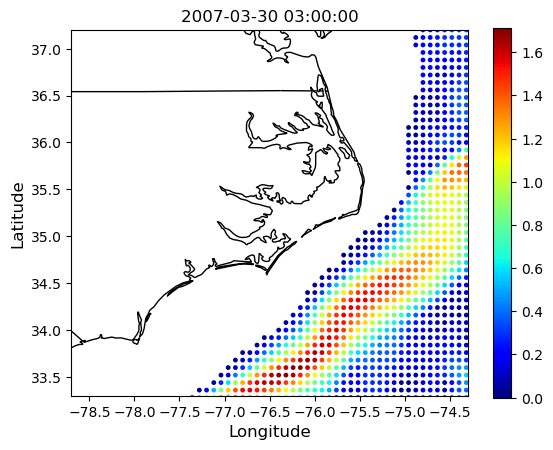

In [5]:
RefDepth=50
RandomTime=np.random.randint(0,len(TimeList))
TimeSample=TimeList[RandomTime]
depthIdx=np.argmin(np.abs(depth-RefDepth))
SpeedSample=OCSpeed[RandomTime,depthIdx,:]
IdxWithData=np.where(SpeedSample!=-1)[0]
PlotGeneralGeoData(LatLong[IdxWithData,:], SpeedSample[IdxWithData],Title=TimeSample.strftime('%Y-%m-%d %H:%M:%S'))